In [152]:
import pandas as pd
import json
import numpy as np
import seaborn as sns

def regression_by_measure(df, measure: str):
    g = sns.FacetGrid(
        df.loc[:,["corpus","tag",measure]].sort_values(measure).replace({k: v for v,k in enumerate(df.sort_values(measure).tag.unique())}), 
        hue="corpus",
        height=6,
        aspect=1.2
    )
    g.map(sns.regplot, "tag", measure, scatter_kws={'alpha':0.4})
    g.add_legend()
    
    return g

def query_regression_by_measure(df, topic: int, measure: str):
    regression_by_measure(df[df['topic'] == topic], measure)

def extract_metadata_from_Tag(tag):
    tag = tag.replace('clueweb12-and-wayback12', 'clueweb12_and_wayback12')
    return dict(list(map(lambda x: x.split("^"), ("collection^"+tag).split("-"))))

def sorted_df(df):
    return df.sort_values("tag",ascending=False)

def import_df(file_name):
    df = pd.read_json(file_name, lines=True)
    df = pd.merge(
        pd.DataFrame(df.tag.apply(lambda t: extract_metadata_from_Tag(t)).tolist()).reset_index(),
        df.reset_index(),
        on="index"
    ).drop(["index","tag"],axis=1)

    df["tag"] = df['body_lang.en'].astype(str)+df['title_lang.en'].astype(str)+df['meta_desc_lang.en'].astype(str)
    
    return sorted_df(df)

def build_topic_df(df, topics: list=None, topic_start: int=None, topic_end: int=None):
    if topics and topic_start and topic_end:
        raise
    elif not topics:
        topics = [i for i in range(topic_start, topic_end+1)]
    nqueries = len(topics)
    df = df[(df['topic'].astype(int).isin(topics))]
    df = df.groupby(['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'tag']).agg({
        #'bpref': np.sum,
        'bpref': np.mean,
        'pseudoNDCG@10': np.mean
        #'pseudoNDCG@10': np.sum
    }).reset_index()
    
    #df['bpref'] = (df['bpref']/nqueries)
    #df['pseudoNDCG@10'] = (df['pseudoNDCG@10']/nqueries)
    
    columns = ['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'bpref', 'pseudoNDCG@10', 'tag']
    if topic_start and topic_end:
        columns = ['collection', 'body_lang.en', 'title_lang.en', 'meta_desc_lang.en', 'corpus', 'topics', 'bpref', 'pseudoNDCG@10', 'tag']
        df['topics'] = 'topics-' + str(topic_start) + '-' + str(topic_end)
    
    df = df[columns]
    
    return sorted_df(df)
    

# Import & Shaping

In [2]:
base_dir = '/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/'
topic_df = import_df(base_dir + 'data-15-10-2020/rankings/reproducibility-evaluation.jsonl')
query_df = import_df(base_dir + 'data-15-10-2020/rankings/reproducibility-evaluation-per-query.jsonl')

In [5]:
tmp_df = build_topic_df(query_df, topic_start=1, topic_end=50)
tmp_df.loc[tmp_df.corpus == "cw09"].sort_values("pseudoNDCG@10",ascending=False)

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topics,bpref,pseudoNDCG@10,tag
366,webis_warc_clueweb09_003,0.8,0.2,0.0,cw09,topics-1-50,0.385901,0.396068,0.80.20.0
336,webis_warc_clueweb09_003,0.6,0.4,0.0,cw09,topics-1-50,0.387839,0.395692,0.60.40.0
408,webis_warc_clueweb09_003,1.0,0.4,0.0,cw09,topics-1-50,0.387214,0.393993,1.00.40.0
294,webis_warc_clueweb09_003,0.4,0.2,0.0,cw09,topics-1-50,0.387730,0.393629,0.40.20.0
372,webis_warc_clueweb09_003,0.8,0.4,0.0,cw09,topics-1-50,0.387730,0.393629,0.80.40.0
...,...,...,...,...,...,...,...,...,...
218,webis_warc_clueweb09_003,0.0,0.0,0.4,cw09,topics-1-50,0.303182,0.281660,0.00.00.4
220,webis_warc_clueweb09_003,0.0,0.0,0.8,cw09,topics-1-50,0.303182,0.281660,0.00.00.8
217,webis_warc_clueweb09_003,0.0,0.0,0.2,cw09,topics-1-50,0.303182,0.281660,0.00.00.2
219,webis_warc_clueweb09_003,0.0,0.0,0.6,cw09,topics-1-50,0.303182,0.281660,0.00.00.6


In [3]:
topic_df[(topic_df.corpus == "cw09") & (topic_df.topics == "topics-1-50")].sort_values("pseudoNDCG@10",ascending=False)

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topics,bpref,pseudoNDCG@10,tag
213,webis_warc_clueweb09_003,0.8,0.2,0.0,cw09,topics-1-50,0.385901,0.396068,0.80.20.0
28,webis_warc_clueweb09_003,0.6,0.4,0.0,cw09,topics-1-50,0.387839,0.395692,0.60.40.0
73,webis_warc_clueweb09_003,1.0,0.4,0.0,cw09,topics-1-50,0.387214,0.393993,1.00.40.0
197,webis_warc_clueweb09_003,0.4,0.2,0.0,cw09,topics-1-50,0.387730,0.393629,0.40.20.0
47,webis_warc_clueweb09_003,0.8,0.4,0.0,cw09,topics-1-50,0.387730,0.393629,0.80.40.0
...,...,...,...,...,...,...,...,...,...
178,webis_warc_clueweb09_003,0.0,0.0,0.8,cw09,topics-1-50,0.303182,0.281660,0.00.00.8
63,webis_warc_clueweb09_003,0.0,0.0,0.6,cw09,topics-1-50,0.303182,0.281660,0.00.00.6
83,webis_warc_clueweb09_003,0.0,0.0,0.4,cw09,topics-1-50,0.303182,0.281660,0.00.00.4
115,webis_warc_clueweb09_003,0.0,0.0,0.2,cw09,topics-1-50,0.303182,0.281660,0.00.00.2


In [102]:
bla = query_df[(query_df['topic'] == 142)]
bla

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topic,bpref,pseudoNDCG@10,tag
79482,webis_warc_clueweb12_011,1.0,1.0,1.0,cw12,142,0.000000,NaN,1.01.01.0
82321,clueweb12_and_wayback12,1.0,1.0,1.0,cw12wb12,142,0.000000,NaN,1.01.01.0
66053,webis_warc_clueweb09_003,1.0,1.0,1.0,cw09,142,0.031250,0.063621,1.01.01.0
68703,webis_warc_clueweb09_003,1.0,1.0,0.8,cw09,142,0.035156,0.066254,1.01.00.8
72462,webis_warc_clueweb12_011,1.0,1.0,0.8,cw12,142,0.000000,NaN,1.01.00.8
...,...,...,...,...,...,...,...,...,...
66703,webis_warc_clueweb09_003,0.0,0.0,0.2,cw09,142,0.000000,NaN,0.00.00.2
81761,clueweb12_and_wayback12,0.0,0.0,0.2,cw12wb12,142,0.000000,0.141267,0.00.00.2
84361,clueweb12_and_wayback12,0.0,0.0,0.0,cw12wb12,142,0.000000,0.181542,0.00.00.0
75306,webis_warc_clueweb12_011,0.0,0.0,0.0,cw12,142,0.000000,0.181542,0.00.00.0


In [106]:
bla = bla.replace("pseudoNDCG@10", float("NaN"), inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [107]:
bla

# Overview

In [4]:
topic_df.loc[topic_df.corpus == "cw09"].sort_values("bpref",ascending=False).head()

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topics,bpref,pseudoNDCG@10,tag
160,webis_warc_clueweb09_003,0.2,0.4,0.0,cw09,topics-1-50,0.390028,0.383165,0.20.40.0
84,webis_warc_clueweb09_003,0.4,0.8,0.0,cw09,topics-1-50,0.390028,0.383165,0.40.80.0
207,webis_warc_clueweb09_003,0.6,1.0,0.0,cw09,topics-1-50,0.389457,0.388231,0.61.00.0
118,webis_warc_clueweb09_003,0.4,0.6,0.0,cw09,topics-1-50,0.388577,0.388740,0.40.60.0
5,webis_warc_clueweb09_003,0.8,1.0,0.0,cw09,topics-1-50,0.388475,0.388503,0.81.00.0


In [5]:
topic_df.loc[topic_df.corpus == "cw12"].sort_values("bpref",ascending=False).head()

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topics,bpref,pseudoNDCG@10,tag
405,webis_warc_clueweb12_011,0.8,1.0,0.6,cw12,topics-1-50,0.506771,0.563842,0.81.00.6
299,webis_warc_clueweb12_011,0.6,0.6,0.4,cw12,topics-1-50,0.506578,0.559057,0.60.60.4
344,webis_warc_clueweb12_011,0.6,0.8,0.4,cw12,topics-1-50,0.506432,0.568009,0.60.80.4
254,webis_warc_clueweb12_011,1.0,1.0,0.6,cw12,topics-1-50,0.506192,0.561272,1.01.00.6
278,webis_warc_clueweb12_011,0.4,0.6,0.4,cw12,topics-1-50,0.506157,0.561567,0.40.60.4


# Regression

###### Regression by bpref

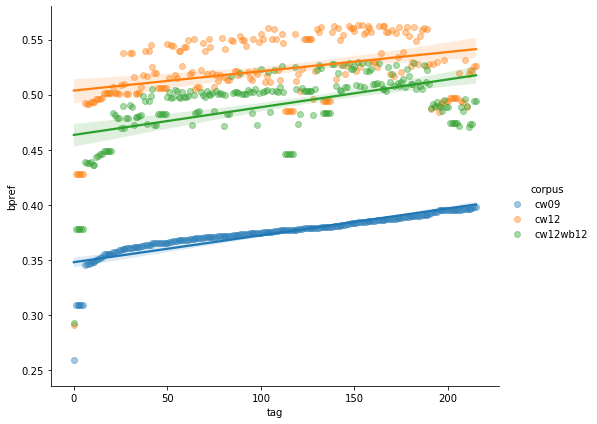

In [74]:
regression_by_measure(build_topic_df(query_df, 1, 50), 'bpref')

In [75]:
build_topic_df(query_df, 1, 50).pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.267606  0.393111      0.668064  0.615943   
              cw12      0.267606  1.000000  0.613277      0.110813  0.457516   
              cw12wb12  0.393111  0.613277  1.000000      0.277811  0.441438   
pseudoNDCG@10 cw09      0.668064  0.110813  0.277811      1.000000  0.451897   
              cw12      0.615943  0.457516  0.441438      0.451897  1.000000   
              cw12wb12  0.558377  0.535483  0.497450      0.425274  0.671017   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.558377  
              cw12      0.535483  
              cw12wb12  0.497450  
pseudoNDCG@10 cw09      0.425274  
              cw12      0.671017  
              cw12wb12  1.000000

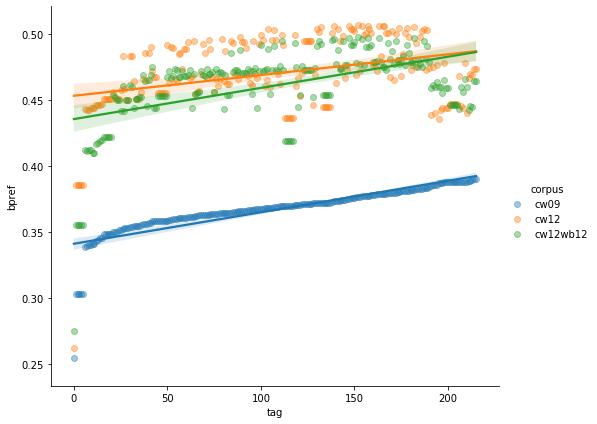

In [13]:
regression_by_measure(topic_df[topic_df['topics'] == 'topics-1-50'], 'bpref')

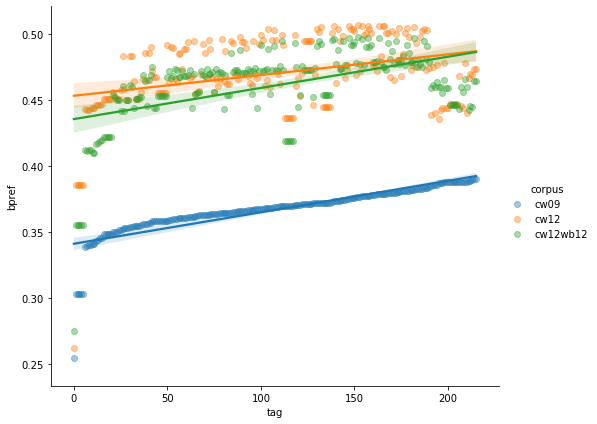

In [3]:
regression_by_measure(topic_df[topic_df['topics'] == 'topics-1-50'], 'bpref')

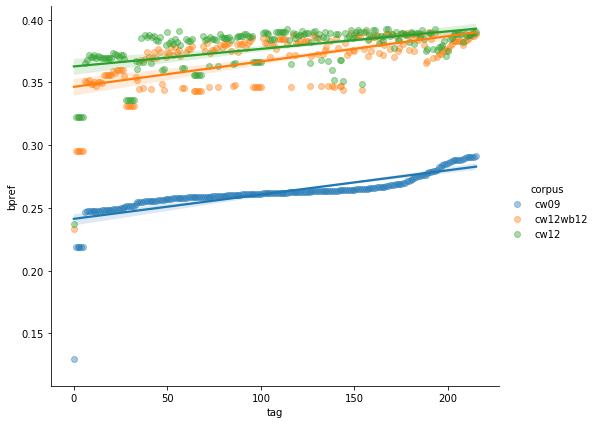

In [4]:
regression_by_measure(topic_df[topic_df['topics'] == 'topics-51-100'], 'bpref')

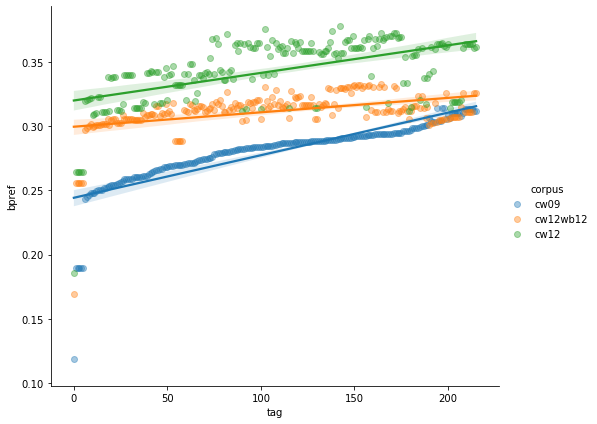

In [5]:
regression_by_measure(topic_df[topic_df['topics'] == 'topics-101-150'], 'bpref')

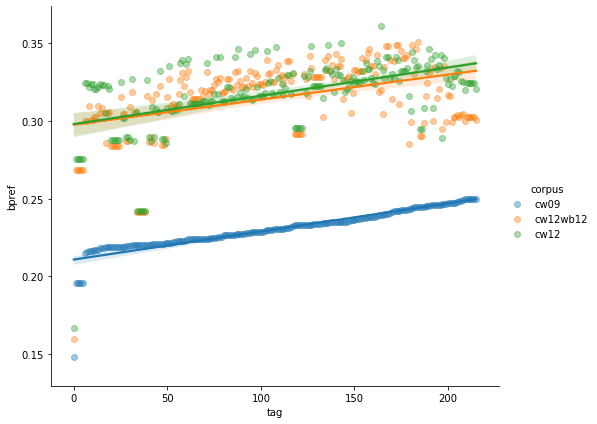

In [6]:
regression_by_measure(topic_df[topic_df['topics'] == 'topics-151-200'], 'bpref')

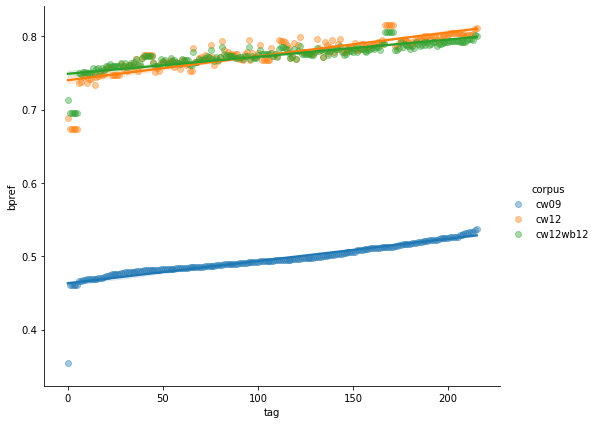

In [14]:
# Topic 17 has the most transferred judgments
query_regression_by_measure(query_df, 17, 'bpref')

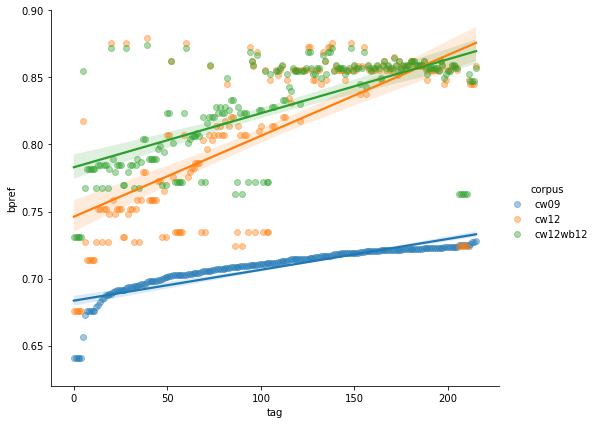

In [15]:
# Topic  21 has the second most transferred judgments
query_regression_by_measure(query_df, 21, 'bpref')

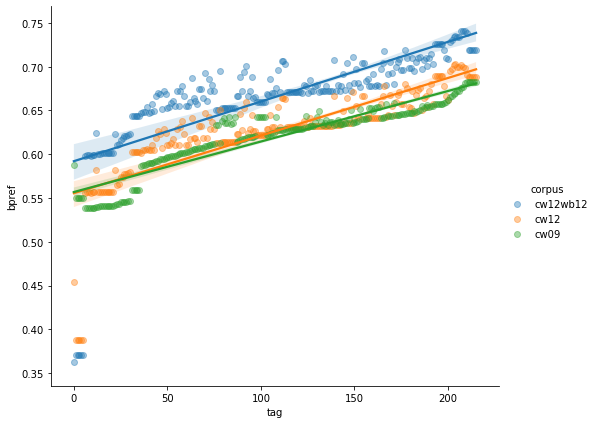

In [16]:
# Topic  31 has the third most transferred judgments
query_regression_by_measure(query_df, 31, 'bpref')

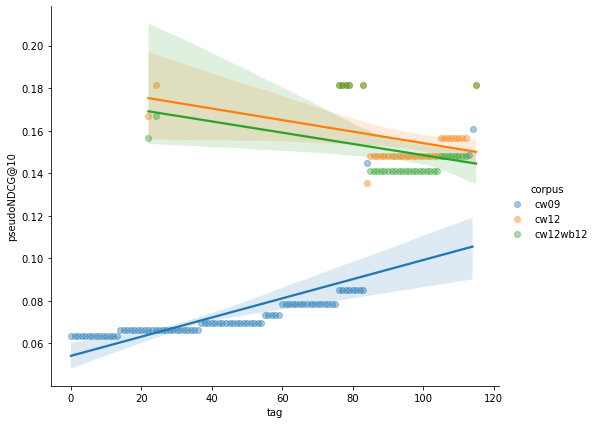

In [98]:
query_regression_by_measure(query_df, 142, 'pseudoNDCG@10')

###### Regression by pseudoNDCG@10

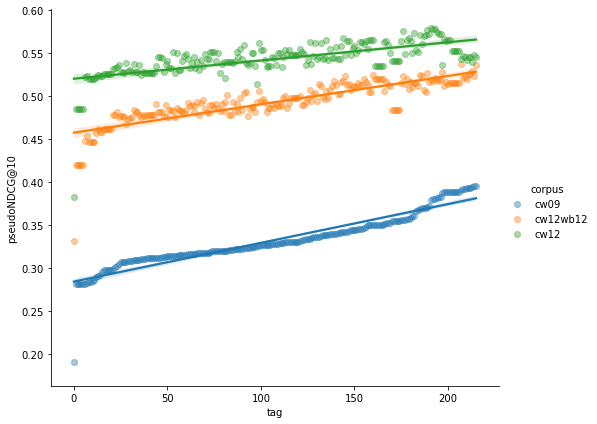

In [17]:
regression_by_measure(topic_df, 'pseudoNDCG@10')

# Correlation

###### Kendall Tau

In [7]:
tmp_df = build_topic_df(query_df, topic_start=1, topic_end=50)
tmp_df[tmp_df['topics'] == 'topics-1-50'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.267167  0.391653      0.841043  0.561602   
              cw12      0.267167  1.000000  0.611436      0.263162  0.593589   
              cw12wb12  0.391653  0.611436  1.000000      0.369974  0.487434   
pseudoNDCG@10 cw09      0.841043  0.263162  0.369974      1.000000  0.556396   
              cw12      0.561602  0.593589  0.487434      0.556396  1.000000   
              cw12wb12  0.786303  0.308634  0.459108      0.750178  0.575507   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.786303  
              cw12      0.308634  
              cw12wb12  0.459108  
pseudoNDCG@10 cw09      0.750178  
              cw12      0.575507  
              cw12wb12  1.000000

In [20]:
topic_df[topic_df['topics'] == 'topics-1-50'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.267606  0.393111      0.842233  0.563044   
              cw12      0.267606  1.000000  0.613277      0.264241  0.595471   
              cw12wb12  0.393111  0.613277  1.000000      0.370905  0.488633   
pseudoNDCG@10 cw09      0.842233  0.264241  0.370905      1.000000  0.557784   
              cw12      0.563044  0.595471  0.488633      0.557784  1.000000   
              cw12wb12  0.788469  0.309015  0.460455      0.751923  0.576627   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.788469  
              cw12      0.309015  
              cw12wb12  0.460455  
pseudoNDCG@10 cw09      0.751923  
              cw12      0.576627  
              cw12wb12  1.000000

In [21]:
topic_df[topic_df['topics'] == 'topics-51-100'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.360611  0.455007      0.246256  0.525704   
              cw12      0.360611  1.000000  0.758102      0.127237  0.647161   
              cw12wb12  0.455007  0.758102  1.000000      0.046582  0.669259   
pseudoNDCG@10 cw09      0.246256  0.127237  0.046582      1.000000  0.211081   
              cw12      0.525704  0.647161  0.669259      0.211081  1.000000   
              cw12wb12  0.217905  0.404356  0.340593      0.417063  0.441006   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.217905  
              cw12      0.404356  
              cw12wb12  0.340593  
pseudoNDCG@10 cw09      0.417063  
              cw12      0.441006  
              cw12wb12  1.000000

In [22]:
topic_df[topic_df['topics'] == 'topics-101-150'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.400899  0.333910      0.487683  0.521393   
              cw12      0.400899  1.000000  0.551128      0.648025  0.801711   
              cw12wb12  0.333910  0.551128  1.000000      0.584666  0.563921   
pseudoNDCG@10 cw09      0.487683  0.648025  0.584666      1.000000  0.708704   
              cw12      0.521393  0.801711  0.563921      0.708704  1.000000   
              cw12wb12  0.557006  0.648544  0.572046      0.763333  0.762296   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.557006  
              cw12      0.648544  
              cw12wb12  0.572046  
pseudoNDCG@10 cw09      0.763333  
              cw12      0.762296  
              cw12wb12  1.000000

In [23]:
topic_df[topic_df['topics'] == 'topics-151-200'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.397001  0.339175      0.583789  0.072651   
              cw12      0.397001  1.000000  0.587951      0.250497  0.397839   
              cw12wb12  0.339175  0.587951  1.000000      0.148587  0.584808   
pseudoNDCG@10 cw09      0.583789  0.250497  0.148587      1.000000 -0.104030   
              cw12      0.072651  0.397839  0.584808     -0.104030  1.000000   
              cw12wb12  0.278670  0.558043  0.636442      0.080647  0.598811   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.278670  
              cw12      0.558043  
              cw12wb12  0.636442  
pseudoNDCG@10 cw09      0.080647  
              cw12      0.598811  
              cw12wb12  1.000000

###### Pearson Correlation

In [8]:
topic_df[topic_df['topics'] == 'topics-1-50'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="pearson")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.610575  0.756125      0.885779  0.853851   
              cw12      0.610575  1.000000  0.880283      0.335527  0.845351   
              cw12wb12  0.756125  0.880283  1.000000      0.477784  0.798745   
pseudoNDCG@10 cw09      0.885779  0.335527  0.477784      1.000000  0.723038   
              cw12      0.853851  0.845351  0.798745      0.723038  1.000000   
              cw12wb12  0.957273  0.606540  0.772790      0.877105  0.841530   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.957273  
              cw12      0.606540  
              cw12wb12  0.772790  
pseudoNDCG@10 cw09      0.877105  
              cw12      0.841530  
              cw12wb12  1.000000

In [9]:
topic_df[topic_df['topics'] == 'topics-51-100'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="pearson")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.717573  0.747736      0.632959  0.678535   
              cw12      0.717573  1.000000  0.961995      0.607528  0.865074   
              cw12wb12  0.747736  0.961995  1.000000      0.493554  0.810985   
pseudoNDCG@10 cw09      0.632959  0.607528  0.493554      1.000000  0.761326   
              cw12      0.678535  0.865074  0.810985      0.761326  1.000000   
              cw12wb12  0.541326  0.772250  0.668410      0.857492  0.859968   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.541326  
              cw12      0.772250  
              cw12wb12  0.668410  
pseudoNDCG@10 cw09      0.857492  
              cw12      0.859968  
              cw12wb12  1.000000

In [10]:
topic_df[topic_df['topics'] == 'topics-101-150'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="pearson")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.736083  0.747733      0.750946  0.840304   
              cw12      0.736083  1.000000  0.818296      0.904866  0.958022   
              cw12wb12  0.747733  0.818296  1.000000      0.817271  0.866701   
pseudoNDCG@10 cw09      0.750946  0.904866  0.817271      1.000000  0.909672   
              cw12      0.840304  0.958022  0.866701      0.909672  1.000000   
              cw12wb12  0.839386  0.906592  0.871039      0.917708  0.954376   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.839386  
              cw12      0.906592  
              cw12wb12  0.871039  
pseudoNDCG@10 cw09      0.917708  
              cw12      0.954376  
              cw12wb12  1.000000

In [11]:
topic_df[topic_df['topics'] == 'topics-151-200'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="pearson")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.619926  0.535993      0.639671  0.344853   
              cw12      0.619926  1.000000  0.878905      0.501453  0.802108   
              cw12wb12  0.535993  0.878905  1.000000      0.325228  0.870159   
pseudoNDCG@10 cw09      0.639671  0.501453  0.325228      1.000000  0.086273   
              cw12      0.344853  0.802108  0.870159      0.086273  1.000000   
              cw12wb12  0.569188  0.873434  0.888639      0.296320  0.901418   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.569188  
              cw12      0.873434  
              cw12wb12  0.888639  
pseudoNDCG@10 cw09      0.296320  
              cw12      0.901418  
              cw12wb12  1.000000

###### Spearman Correlation

In [14]:
topic_df[topic_df['topics'] == 'topics-1-50'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="spearman")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.323835  0.494831      0.960646  0.740329   
              cw12      0.323835  1.000000  0.807083      0.291019  0.757959   
              cw12wb12  0.494831  0.807083  1.000000      0.436799  0.642531   
pseudoNDCG@10 cw09      0.960646  0.291019  0.436799      1.000000  0.734541   
              cw12      0.740329  0.757959  0.642531      0.734541  1.000000   
              cw12wb12  0.938374  0.365675  0.568489      0.906768  0.737283   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.938374  
              cw12      0.365675  
              cw12wb12  0.568489  
pseudoNDCG@10 cw09      0.906768  
              cw12      0.737283  
              cw12wb12  1.000000

In [15]:
topic_df[topic_df['topics'] == 'topics-51-100'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="spearman")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.521947  0.618667      0.392007  0.704767   
              cw12      0.521947  1.000000  0.907236      0.195075  0.818237   
              cw12wb12  0.618667  0.907236  1.000000      0.100958  0.845679   
pseudoNDCG@10 cw09      0.392007  0.195075  0.100958      1.000000  0.306841   
              cw12      0.704767  0.818237  0.845679      0.306841  1.000000   
              cw12wb12  0.333310  0.577570  0.495022      0.574696  0.592462   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.333310  
              cw12      0.577570  
              cw12wb12  0.495022  
pseudoNDCG@10 cw09      0.574696  
              cw12      0.592462  
              cw12wb12  1.000000

In [16]:
topic_df[topic_df['topics'] == 'topics-101-150'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="spearman")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.526285  0.424967      0.633330  0.648633   
              cw12      0.526285  1.000000  0.705282      0.837859  0.944031   
              cw12wb12  0.424967  0.705282  1.000000      0.755555  0.692310   
pseudoNDCG@10 cw09      0.633330  0.837859  0.755555      1.000000  0.882030   
              cw12      0.648633  0.944031  0.692310      0.882030  1.000000   
              cw12wb12  0.679271  0.840696  0.703894      0.922385  0.919817   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.679271  
              cw12      0.840696  
              cw12wb12  0.703894  
pseudoNDCG@10 cw09      0.922385  
              cw12      0.919817  
              cw12wb12  1.000000

In [17]:
topic_df[topic_df['topics'] == 'topics-151-200'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="spearman")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.537753  0.399132      0.774812  0.077057   
              cw12      0.537753  1.000000  0.741839      0.355363  0.527495   
              cw12wb12  0.399132  0.741839  1.000000      0.192493  0.764889   
pseudoNDCG@10 cw09      0.774812  0.355363  0.192493      1.000000 -0.153713   
              cw12      0.077057  0.527495  0.764889     -0.153713  1.000000   
              cw12wb12  0.379353  0.748779  0.818799      0.113383  0.795701   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.379353  
              cw12      0.748779  
              cw12wb12  0.818799  
pseudoNDCG@10 cw09      0.113383  
              cw12      0.795701  
              cw12wb12  1.000000

# Topic Level Correlation

In [11]:
tmp_df = build_topic_df(query_df, topic_start=1, topic_end=50)
[i for i in tmp_df[tmp_df['topics'] == 'topics-1-50'].pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall").iterrows()][0]

(('bpref', 'cw09'),
                corpus  
 bpref          cw09        1.000000
                cw12        0.267167
                cw12wb12    0.391653
 pseudoNDCG@10  cw09        0.841043
                cw12        0.561602
                cw12wb12    0.786303
 Name: (bpref, cw09), dtype: float64)

In [121]:
def extract_correlation(corr, measure, src, target):
    for k,v in corr.iterrows():
        if k == (measure, src):
            try:
                ret = v[measure][target]
                if ret != ret:
                    return -100
                else:
                    return ret
            except:
                return -100
    return -100

def correlation_per_topic(query_df, topic: int):
    query_df = query_df[query_df['topic'].astype(int) == topic].copy()
    query_df["bpref"] = query_df["bpref"].fillna(0)
    query_df["pseudoNDCG@10"] = query_df["pseudoNDCG@10"].fillna(0)
    corr = query_df.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")
    
    return {
        'topic': topic,
        'source': 'cw09',
        'bpref-to-cw12': extract_correlation(corr, 'bpref', 'cw09', 'cw12'),
        'bpref-to-cw12wb12': extract_correlation(corr, 'bpref', 'cw09', 'cw12wb12'),
        'pseudoNDCG@10-to-cw12': extract_correlation(corr, 'pseudoNDCG@10', 'cw09', 'cw12'),
        'pseudoNDCG@10-to-cw12wb12': extract_correlation(corr, 'pseudoNDCG@10', 'cw09', 'cw12wb12')
    }

In [122]:
correlation_per_topic(query_df, 1)

{'topic': 1,
 'source': 'cw09',
 'bpref-to-cw12': -100,
 'bpref-to-cw12wb12': -100,
 'pseudoNDCG@10-to-cw12': -100,
 'pseudoNDCG@10-to-cw12wb12': -100}

In [35]:
query_df[query_df['topic'].astype(int) == 1]

,collection,body_lang.en,title_lang.en,meta_desc_lang.en,corpus,topic,bpref,pseudoNDCG@10,tag
4998,webis_warc_clueweb09_003,1.0,1.0,1.0,cw09,1,0.611797,0.489280,1.01.01.0
7595,webis_warc_clueweb09_003,1.0,1.0,0.8,cw09,1,0.620027,0.541098,1.01.00.8
2450,webis_warc_clueweb09_003,1.0,1.0,0.6,cw09,1,0.622771,0.541098,1.01.00.6
588,webis_warc_clueweb09_003,1.0,1.0,0.4,cw09,1,0.628258,0.611469,1.01.00.4
5586,webis_warc_clueweb09_003,1.0,1.0,0.2,cw09,1,0.626886,0.572817,1.01.00.2
...,...,...,...,...,...,...,...,...,...
8722,webis_warc_clueweb09_003,0.0,0.0,0.8,cw09,1,0.342936,0.232347,0.00.00.8
3087,webis_warc_clueweb09_003,0.0,0.0,0.6,cw09,1,0.342936,0.232347,0.00.00.6
4067,webis_warc_clueweb09_003,0.0,0.0,0.4,cw09,1,0.342936,0.232347,0.00.00.4
5635,webis_warc_clueweb09_003,0.0,0.0,0.2,cw09,1,0.342936,0.232347,0.00.00.2


In [124]:
correlation_per_topic(query_df, 2)

{'topic': 2,
 'source': 'cw09',
 'bpref-to-cw12': 0.09711580307487758,
 'bpref-to-cw12wb12': 0.2355678068254735,
 'pseudoNDCG@10-to-cw12': 0.09686330856157153,
 'pseudoNDCG@10-to-cw12wb12': 0.13465820252550917}

In [125]:
correlation_per_topic(query_df, 2)

{'topic': 2,
 'source': 'cw09',
 'bpref-to-cw12': 0.09711580307487758,
 'bpref-to-cw12wb12': 0.2355678068254735,
 'pseudoNDCG@10-to-cw12': 0.09686330856157153,
 'pseudoNDCG@10-to-cw12wb12': 0.13465820252550917}

In [63]:
def print_bla(corr, measure):
    for t in sorted(corr, key=lambda i: i[measure]):
        print(str(t['topic']) + ' --> ' + str(t[measure]))

In [126]:
correlations = [correlation_per_topic(query_df, i) for i in range(1, 51)]
print_bla(correlations, 'bpref-to-cw12')

1 --> -100
6 --> -100
19 --> -100
20 --> -100
28 --> -100
37 --> -100
40 --> -100
38 --> -0.40914055436366115
16 --> -0.3148510504874039
35 --> -0.27146761545085324
39 --> -0.2561956712962056
36 --> -0.2252920204301158
25 --> -0.19634094886902603
22 --> -0.14337095525698174
4 --> -0.12093684915402933
30 --> -0.0775225578462356
12 --> 0.01423049104851152
24 --> 0.031368892511503085
29 --> 0.045076932706069495
42 --> 0.04889956697968452
11 --> 0.08566470513015219
2 --> 0.09711580307487758
48 --> 0.10675126086513785
9 --> 0.13733801273304505
33 --> 0.15406756962625084
34 --> 0.22674556828693845
14 --> 0.27072966080841243
7 --> 0.3051006650136377
5 --> 0.35503842060727125
43 --> 0.38614273309803027
27 --> 0.3959129174399512
18 --> 0.44265887749799665
50 --> 0.4614750644994385
8 --> 0.499761546216654
21 --> 0.5042885689960456
41 --> 0.517791489106945
15 --> 0.5303135045005981
46 --> 0.5315079058082757
44 --> 0.5999256667351794
23 --> 0.6050933150116411
49 --> 0.6082879988141967
10 --> 0.634

In [175]:
def bla_tmp(query_df, measure, key):
    correlations = [correlation_per_topic(query_df, i) for i in range(1, 201)]
    tmp = sorted(correlations, key=key, reverse=False)
    ret = {}
    for i in range(1,len(correlations)+1):
        selected_topics = [j['topic'] for j in tmp[len(correlations)-i:]]
        tmp_df = build_topic_df(query_df, topics=selected_topics)
        corr = tmp_df.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")
        corr = extract_correlation(corr, measure.split('-to-')[0], 'cw09', measure.split('-to-')[1])
        ret[i] = corr
        print(str(len(selected_topics)) + '-->' + str(corr))
    
    return ret


In [157]:
tmp_for_plotting = {}

for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
    tmp_for_plotting[measure]= bla_tmp(query_df, measure, lambda i: i[measure])


1-->0.9249310224218645
2-->0.8356054530874097
3-->0.863010002753507
4-->0.9493858157212263
5-->0.7460037468013926
6-->0.5358794776347733
7-->0.6451794114331663
8-->0.8462418777065844
9-->0.8071129556593638
10-->0.8971576641058733
11-->0.9202356091432627
12-->0.8744984692551028
13-->0.89496520687381
14-->0.9265641773025581
15-->0.9363418687598261
16-->0.8679953482808836
17-->0.8660554467379753
18-->0.877968807504145
19-->0.878362346242876
20-->0.902332214557413
21-->0.9023685307902392
22-->0.8716356180634892
23-->0.8229229605295799
24-->0.8254933772501623
25-->0.8186445986558645
26-->0.8120430797739983
27-->0.8076201388136701
28-->0.8013713666845744
29-->0.8545431309380361
30-->0.8628288127395951
31-->0.8749595804433851
32-->0.8559415245283812
33-->0.7958519952799022
34-->0.8030100508541914
35-->0.814000129580493
36-->0.8156629684144601
37-->0.8095207312709037
38-->0.7767476138990378
39-->0.7647363549610361
40-->0.7585775735380863
41-->0.7840583150047349
42-->0.7983956198105728
43-->0.8

139-->0.5419441094255752
140-->0.5358012604987115
141-->0.5281986226895403
142-->0.5261615553915012
143-->0.5288882391894287
144-->0.5351092843797415
145-->0.5409284928197767
146-->0.5456230415989728
147-->0.5459207987803445
148-->0.5325661083590376
149-->0.5339711682667083
150-->0.5327845903092266
151-->0.5254288428291924
152-->0.5182742871807923
153-->0.5200956835895119
154-->0.5141244213711547
155-->0.47869178514405303
156-->0.4734903249484504
157-->0.4666164008682945
158-->0.46739927434335
159-->0.4543750413491651
160-->0.45712315950172283
161-->0.45745437318038545
162-->0.4660332261545812
163-->0.46795673016782185
164-->0.46784029231420887
165-->0.4672297156059193
166-->0.46719669069082026
167-->0.463434605041399
168-->0.4633815260389164
169-->0.46332844953891245
170-->0.463434605041399
171-->0.4725478383351949
172-->0.47047922946696974
173-->0.47067189980960716
174-->0.468848999553868
175-->0.47449518625561066
176-->0.4732804688846751
177-->0.4718379663937398
178-->0.478193416704

74-->0.5908650046170977
75-->0.5712499742506361
76-->0.5649624967669626
77-->0.5824012447338097
78-->0.5614209051894976
79-->0.5370206723447418
80-->0.5361606802856529
81-->0.48722038024222863
82-->0.5138152582949832
83-->0.5090078484062348
84-->0.4924694632731623
85-->0.47520741310462705
86-->0.4890756343392962
87-->0.5135321496293743
88-->0.5155994182531521
89-->0.49809239862803395
90-->0.49976292127984895
91-->0.5079529290055605
92-->0.539274017271021
93-->0.5518148162359804
94-->0.5443534528269741
95-->0.5423319859784143
96-->0.5337069089464485
97-->0.5484441077968434
98-->0.5580242813514059
99-->0.5058511765160248
100-->0.5371236460288553
101-->0.5500668178239836
102-->0.5467321952060701
103-->0.568282224319764
104-->0.5848402069565612
105-->0.587043297347897
106-->0.5939608198810558
107-->0.598258550629188
108-->0.6112835106099939
109-->0.6011166923163681
110-->0.6120522441998081
111-->0.6268746860940537
112-->0.6227614606898955
113-->0.6216408434860794
114-->0.6157427370148919
1

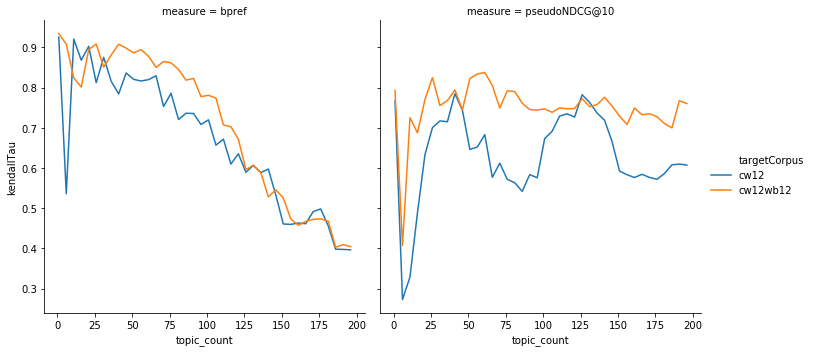

In [151]:
bla = []
for topic_count in range(1, 201, 5):
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
        bla += [{'topic_count': topic_count,
                 'measure': measure.split('-to-')[0],
                 'targetCorpus': measure.split('-to-')[1],
                 'kendallTau': tmp_for_plotting[measure][topic_count]
            }]

sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')

In [185]:
def load_topic_criteria():
    ret = {'cw12': {}, 'cw12wb12': {}}
    
    with open('/mnt/ceph/storage/data-in-progress/kibi9872/sigir2021/data-15-10-2020/topic-selection-features.jsonl', 'r') as f:
        for jsonline in f:
            parsed_json = json.loads(jsonline)
            tmp_count = parsed_json['labelCount']
            if parsed_json['possibleLabelPermutations'] <= 3:
                tmp_count = 1
            
            ret[parsed_json['targetCorpus']][parsed_json['topic']] = {
                'labelCount': parsed_json['labelCount'],
                'possibleLabelPermutations': parsed_json['possibleLabelPermutations'],
                'tmp_count': tmp_count
            }
        
        return ret

In [186]:
tmp_for_plotting2 = {}
tmp_for_plotting3 = {}
tmp_for_plotting4 = {}

topic_criteria = load_topic_criteria()
def tmp_topic_selection_criteria(i, measure, key):
    topic = int(i['topic'])
    corpus = measure.split('-to-')[1]
    measure = measure.split('-to-')[0]
    
    if topic in topic_criteria[corpus] and key in topic_criteria[corpus][topic]:
        return topic_criteria[corpus][topic][key]
    else:
        print('Could not handle topic ' + str(topic) + ' for ' + measure + ' @ ' + corpus)
        return -1

for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
    tmp_for_plotting2[measure]= bla_tmp(query_df, measure, lambda i: tmp_topic_selection_criteria(i, measure, 'possibleLabelPermutations'))
    tmp_for_plotting3[measure]= bla_tmp(query_df, measure, lambda i: tmp_topic_selection_criteria(i, measure, 'labelCount'))
    tmp_for_plotting4[measure]= bla_tmp(query_df, measure, lambda i: tmp_topic_selection_criteria(i, measure, 'tmp_count'))

Could not handle topic 95 for bpref @ cw12
Could not handle topic 100 for bpref @ cw12
1-->0.7744015577970879
2-->0.6308644290368448
3-->0.6203844032548324
4-->0.7387165707866026
5-->0.7242466216280954
6-->0.8344919901550154
7-->0.8360051153476714
8-->0.8476127221160517
9-->0.8685260846601299
10-->0.8136609874669632
11-->0.8625801602981837
12-->0.8599844867032078
13-->0.8135272019552844
14-->0.8496312150330471
15-->0.8019667555954605
16-->0.8211829232984837
17-->0.7889085342188106
18-->0.8139008149579905
19-->0.7974814677909231
20-->0.7545128228984123
21-->0.5557329044854126
22-->0.5388379895485186
23-->0.5680146959609716
24-->0.5983348454174914
25-->0.6489680643306226
26-->0.6613609405183245
27-->0.5532575706253067
28-->0.557922892801836
29-->0.6332018145408508
30-->0.6333060386077941
31-->0.6404191732337355
32-->0.6403484222543354
33-->0.671682981091007
34-->0.6693395717782192
35-->0.6736388705536618
36-->0.6837157156608106
37-->0.6884299108350986
38-->0.6939154145911979
39-->0.72390

132-->0.6109949789148024
133-->0.6271036698505951
134-->0.6271653935024134
135-->0.6250619581590645
136-->0.6278523575358023
137-->0.6350218699627521
138-->0.6242727378490006
139-->0.6199689741169502
140-->0.6314836764746051
141-->0.6448026256269572
142-->0.6139556934747005
143-->0.61994353584363
144-->0.6176622710676036
145-->0.6112140694170605
146-->0.6233245700986941
147-->0.6074852945755236
148-->0.6178048834484183
149-->0.6098780352785801
150-->0.5405731568554174
151-->0.5451842320932625
152-->0.5463908686041006
153-->0.5367987760131105
154-->0.5369879605123393
155-->0.5371519716534011
156-->0.4982439509031853
157-->0.4983623531699219
158-->0.5228972275652164
159-->0.5228746903487517
160-->0.5206654311942421
161-->0.45238454504817927
162-->0.4460676582465614
163-->0.44555074254436516
164-->0.4353017306079331
165-->0.4426964354984699
166-->0.4495873702219749
167-->0.4782880551600024
168-->0.4832431985965591
169-->0.5131343663595431
170-->0.5080918005705105
171-->0.5155296936932189


60-->0.7404167296855585
61-->0.7414238924323393
62-->0.7274059415894194
63-->0.7471234675454995
64-->0.7380895948620312
65-->0.7654017799919058
66-->0.7655576738467461
67-->0.7631238750110747
68-->0.7659785379694879
69-->0.7467994372541741
70-->0.7234987524855734
71-->0.7228089946664102
72-->0.6939092208696748
73-->0.6674138953085322
74-->0.6675002155729929
75-->0.6746868478851513
76-->0.6735498929036577
77-->0.6486719775549153
78-->0.6635342803877539
79-->0.6408156233052751
80-->0.6402828454604705
81-->0.6293374720274103
82-->0.6205677651309448
83-->0.6213140479497421
84-->0.6317445291523595
85-->0.6344690966526828
86-->0.6383639061492867
87-->0.6564944734740044
88-->0.6644251907409802
89-->0.6664080219753717
90-->0.6033572556406974
91-->0.6196879631147201
92-->0.6378192042195405
93-->0.624070683342691
94-->0.6314587373410901
95-->0.6403913310864549
96-->0.6555766399396348
97-->0.6529161036911789
98-->0.6425339366515836
99-->0.6328290106567658
100-->0.6231225084950751
101-->0.61588519

190-->0.3842606573771338
191-->0.3845324830059236
192-->0.3931889213112923
193-->0.393931559087867
194-->0.3953197724530254
195-->0.40904193765158703
196-->0.40907622160378215
197-->0.40102573092129096
198-->0.40785986769965943
199-->0.40785986769965943
200-->0.40785986769965943
Could not handle topic 95 for bpref @ cw12wb12
Could not handle topic 100 for bpref @ cw12wb12
1-->-0.016357449941793636
2-->0.5163706773106145
3-->0.2752186733323764
4-->0.315384958121181
5-->0.21412232041037232
6-->0.3531468544629361
7-->0.5497626245948931
8-->0.585943569357163
9-->0.6336834458738742
10-->0.6053716205196881
11-->0.5349153484001963
12-->0.40340014999628854
13-->0.48767654997860854
14-->0.5060916537353666
15-->0.5988050288285641
16-->0.5979599353300358
17-->0.5956262989825178
18-->0.6520623595968627
19-->0.7251083666594853
20-->0.7431319335930817
21-->0.6787277755847634
22-->0.7199292767378163
23-->0.7221443890174962
24-->0.6833592291426562
25-->0.7005325818092909
26-->0.7482911261715861
27-->0

118-->0.4785054113349107
119-->0.49412830337248587
120-->0.48568167021800684
121-->0.4715363138359705
122-->0.46655462296141875
123-->0.46853450408571573
124-->0.4940943643827226
125-->0.4793794512073968
126-->0.4606102434635021
127-->0.448261015719681
128-->0.46865640795184915
129-->0.5010882240769654
130-->0.4932233110599013
131-->0.47920170085786906
132-->0.4896991861518258
133-->0.48495949379629394
134-->0.48566072980121777
135-->0.5219452431620158
136-->0.5223761754961984
137-->0.5076923152350181
138-->0.5215480109012794
139-->0.5341465022495943
140-->0.540815454981123
141-->0.5452782207663462
142-->0.5527733503274022
143-->0.5343103453239357
144-->0.5381034487757351
145-->0.5319713037287643
146-->0.5403180643267302
147-->0.5419755234750033
148-->0.5180572358415755
149-->0.5217503717842142
150-->0.4974033110329494
151-->0.4991919462750852
152-->0.49565799655613874
153-->0.4973928259060896
154-->0.48096192485267264
155-->0.4864445538704971
156-->0.4870153688756155
157-->0.497791186

42-->0.5321836602716103
43-->0.522040913229431
44-->0.5704430344664241
45-->0.6357932864811189
46-->0.6853780005278324
47-->0.7197982243475428
48-->0.7154930851983462
49-->0.7299418086552417
50-->0.7580022934558808
51-->0.7641365181442975
52-->0.7488360069038409
53-->0.7606896579989955
54-->0.7679872404428844
55-->0.7140485905983494
56-->0.7292834597727755
57-->0.7236986880427793
58-->0.71633040245908
59-->0.7457210612664384
60-->0.723181378815469
61-->0.6760782024054149
62-->0.6817682255320098
63-->0.722977778903619
64-->0.7239848269507917
65-->0.7278487848480149
66-->0.7097775715978819
67-->0.6949514117387842
68-->0.6462500054030266
69-->0.7098790728559288
70-->0.7245764538517913
71-->0.6912649058171008
72-->0.6885062307586816
73-->0.6941397203680291
74-->0.672343912318695
75-->0.6935115352359719
76-->0.6518936900616926
77-->0.6846959470334819
78-->0.6721403352270554
79-->0.6566958345161531
80-->0.6590943503960234
81-->0.5884786999963516
82-->0.5346782268364909
83-->0.534097771515022

170-->0.46894324272859633
171-->0.4284421476805304
172-->0.4318803732876426
173-->0.43003663043594204
174-->0.431231412439119
175-->0.4357626314721368
176-->0.4394406307394521
177-->0.4377828741129216
178-->0.4400051866801962
179-->0.4400051866801962
180-->0.4463266111102424
181-->0.469442305154344
182-->0.47552961804066235
183-->0.4759359840410327
184-->0.475853908423429
185-->0.47476620504967837
186-->0.4763833892536553
187-->0.46914060701478455
188-->0.4677614155196562
189-->0.46450891049613585
190-->0.4672140066745064
191-->0.4678145993123674
192-->0.46756607446854126
193-->0.46502308051632485
194-->0.4653377999499831
195-->0.46581899321159376
196-->0.46581899321159376
197-->0.4599107983967277
198-->0.4761884349667661
199-->0.4761884349667661
200-->0.4761884349667661
Could not handle topic 95 for pseudoNDCG@10 @ cw12
Could not handle topic 100 for pseudoNDCG@10 @ cw12
1-->0.200157845502857
2-->0.07496462787750985
3-->0.08815164568841485
4-->-0.0035912866387907056
5-->-0.07012011997

94-->0.4232849854749505
95-->0.44058371130794816
96-->0.48373677164488627
97-->0.4587591121894669
98-->0.47579637451149054
99-->0.45052268657608885
100-->0.41007737368856834
101-->0.3520917301505342
102-->0.3634600495859253
103-->0.343885361093801
104-->0.34736139146171585
105-->0.3474269472436866
106-->0.39748286748700795
107-->0.39654317804083966
108-->0.4090850324878399
109-->0.39142426782783035
110-->0.41136799704369337
111-->0.41660742385822486
112-->0.3877612583494936
113-->0.42188274341309334
114-->0.4212295606779779
115-->0.4495733130630224
116-->0.4654800900719776
117-->0.48703971323987244
118-->0.486530760215594
119-->0.4985561082973587
120-->0.5181115015442225
121-->0.5222263021339424
122-->0.5270008232645249
123-->0.5314884306692045
124-->0.5734787446504409
125-->0.5975778222139644
126-->0.6171483267696288
127-->0.6125966958865694
128-->0.5947378740068433
129-->0.6066796089982486
130-->0.5896701302258667
131-->0.5758862353368226
132-->0.6051202572469689
133-->0.627203381203

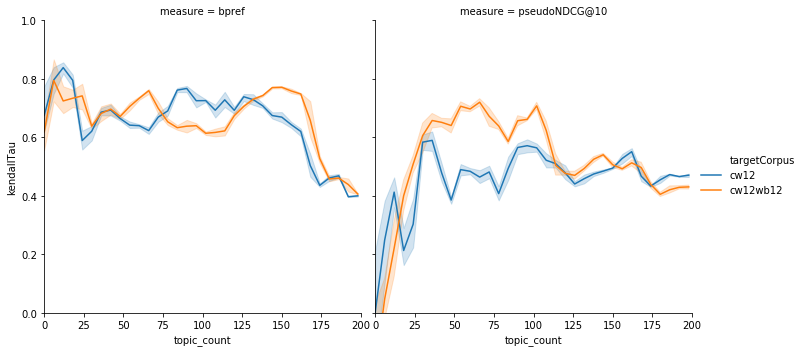

In [182]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
        bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                 'measure': measure.split('-to-')[0],
                 'targetCorpus': measure.split('-to-')[1],
                 'kendallTau': tmp_for_plotting2[measure][topic_count]
            }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))

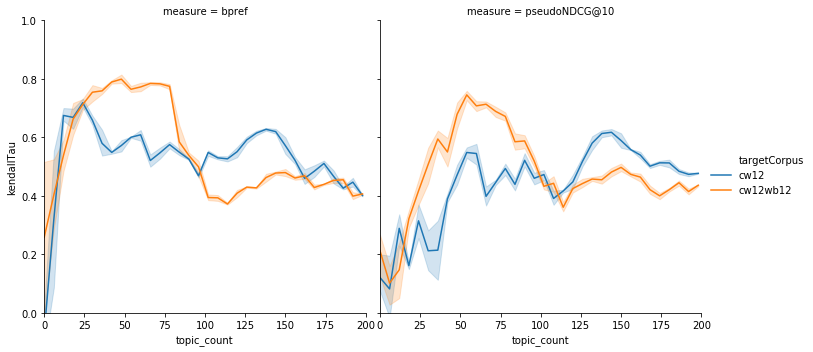

In [184]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
        bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                 'measure': measure.split('-to-')[0],
                 'targetCorpus': measure.split('-to-')[1],
                 'kendallTau': tmp_for_plotting3[measure][topic_count]
            }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))

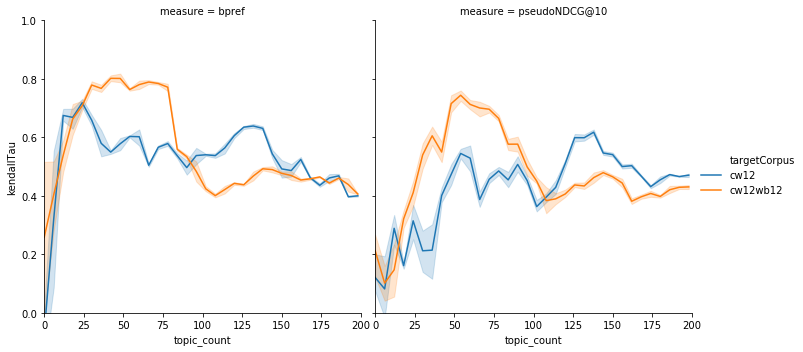

In [187]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
        bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                 'measure': measure.split('-to-')[0],
                 'targetCorpus': measure.split('-to-')[1],
                 'kendallTau': tmp_for_plotting4[measure][topic_count]
            }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))

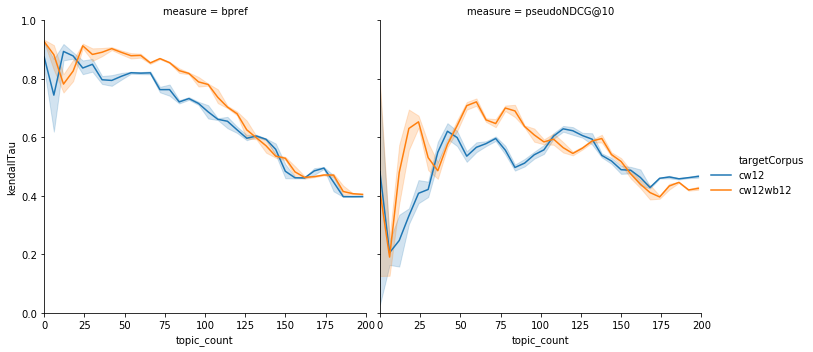

In [167]:
bla = []
for topic_count in range(1, 201):
    plotting_base = 6
    for measure in ['bpref-to-cw12', 'bpref-to-cw12wb12', 'pseudoNDCG@10-to-cw12wb12', 'pseudoNDCG@10-to-cw12']:
        bla += [{'topic_count': plotting_base * round(topic_count/plotting_base),
                 'measure': measure.split('-to-')[0],
                 'targetCorpus': measure.split('-to-')[1],
                 'kendallTau': tmp_for_plotting[measure][topic_count]
            }]

plt_bla = sns.relplot(data=pd.DataFrame(bla), x='topic_count', y='kendallTau', hue='targetCorpus', col='measure', kind='line')
plt_bla.set(xlim=(0,200),ylim=(0,1))

In [155]:
tmp_bla = build_topic_df(query_df, topic_start=1, topic_end=200)
tmp_bla["tag"] = tmp_bla["tag"] + tmp_bla["topics"]

# Unterschied micro vs macro avg
tmp_bla.pivot("tag","corpus",["bpref","pseudoNDCG@10"]).corr(method="kendall")

bpref                     pseudoNDCG@10            \
corpus                      cw09      cw12  cw12wb12          cw09      cw12   
              corpus                                                           
bpref         cw09      1.000000  0.402775  0.407860      0.639357  0.466606   
              cw12      0.402775  1.000000  0.751045      0.450488  0.776463   
              cw12wb12  0.407860  0.751045  1.000000      0.303601  0.665331   
pseudoNDCG@10 cw09      0.639357  0.450488  0.303601      1.000000  0.476188   
              cw12      0.466606  0.776463  0.665331      0.476188  1.000000   
              cw12wb12  0.401508  0.772519  0.707284      0.436889  0.742956   

                                  
corpus                  cw12wb12  
              corpus              
bpref         cw09      0.401508  
              cw12      0.772519  
              cw12wb12  0.707284  
pseudoNDCG@10 cw09      0.436889  
              cw12      0.742956  
              cw12wb12  1.000000

In [131]:
bla_tmp(query_df, 'bpref-to-cw12')

1-->0.9249310224218645
2-->0.8356054530874097
3-->0.863010002753507
4-->0.9493858157212263
5-->0.7460037468013926
6-->0.5358794776347733
7-->0.6451794114331663
8-->0.8462418777065844
9-->0.8071129556593638
10-->0.8971576641058733
11-->0.9202356091432627
12-->0.8744984692551028
13-->0.89496520687381
14-->0.9265641773025581
15-->0.9363418687598261
16-->0.8679953482808836
17-->0.8660554467379753
18-->0.877968807504145
19-->0.878362346242876
20-->0.902332214557413
21-->0.9023685307902392
22-->0.8716356180634892
23-->0.8229229605295799
24-->0.8254933772501623
25-->0.8186445986558645
26-->0.8120430797739983
27-->0.8076201388136701
28-->0.8013713666845744
29-->0.8545431309380361
30-->0.8628288127395951
31-->0.8749595804433851
32-->0.8559415245283812
33-->0.7958519952799022
34-->0.8030100508541914
35-->0.814000129580493
36-->0.8156629684144601
37-->0.8095207312709037
38-->0.7767476138990378
39-->0.7647363549610361
40-->0.7585775735380863
41-->0.7840583150047349
42-->0.7983956198105728
43-->0.8

In [128]:
bla_tmp(query_df, 'bpref-to-cw12wb12')

1-->0.9337404677721132
2-->0.924095597392608
3-->0.924095597392608
4-->0.8858965009841591
5-->0.9134511515361018
6-->0.9077441376755999
7-->0.9215356082217145
8-->0.7848647760962658
9-->0.7633640590374301
10-->0.8048764701409759
11-->0.823750437286023
12-->0.7458029461125469
13-->0.7276219255805703
14-->0.7528700934392157
15-->0.8580307433051116
16-->0.801173756182469
17-->0.7664438242879228
18-->0.8479579180981884
19-->0.8272662586180608
20-->0.8909887172267363
21-->0.8943997586881062
22-->0.9045575187947104
23-->0.9239528973785698
24-->0.9269113440226915
25-->0.9180200635716194
26-->0.9079185715517986
27-->0.9155436746982937
28-->0.896637985155983
29-->0.9085811744930291
30-->0.9043092114455372
31-->0.8506004890689954
32-->0.8578633210006769
33-->0.8622615087560968
34-->0.874169908134193
35-->0.8820207800353271
36-->0.8808399680353193
37-->0.9114546296795761
38-->0.9137644922269209
39-->0.9135328830627887
40-->0.9119137824603848
41-->0.9075343951166559
42-->0.8958944414821889
43-->0.

In [113]:
bla_tmp(query_df, 'bpref-to-cw12wb12')

1-->0.9132316764445155
2-->0.9337404677721132
3-->0.8689956989776317
4-->0.919327658471244
5-->0.8910249738508274
6-->0.8906355685562202
7-->0.9011876560198246
8-->0.8867781977241503
9-->0.881034632482177
10-->0.8809811744727484
11-->0.8659976423209654
12-->0.8583331984451265
13-->0.8703872209184258
14-->0.7854693147767802
15-->0.8758227424423861
16-->0.8797343167005071
17-->0.8774133395038288
18-->0.8836166393690882
19-->0.8742990283594656
20-->0.8828199556982156
21-->0.88993853142666
22-->0.8977849319098176
23-->0.8996398159280597
24-->0.9052250587515138
25-->0.9155312253209186
26-->0.9082011173370486
27-->0.9047855267054985
28-->0.8864930169251924
29-->0.8793289343166429
30-->0.8640265807225197
31-->0.866662353827713
32-->0.8833247198414832
33-->0.8871733074314909
34-->0.8914806083446819
35-->0.8973115202082923
36-->0.9009980207136844
37-->0.9062958247462675
38-->0.8982214079914249
39-->0.868415946386705
40-->0.8664438953122193
41-->0.8736603791865373
42-->0.8684403464660687
43-->0.

In [129]:
bla_tmp(query_df, 'pseudoNDCG@10-to-cw12')

1-->0.766508150726376
2-->0.8579405989646566
3-->0.2122371431541296
4-->0.4657495695206531
5-->0.3754158579581051
6-->0.2728568407384623
7-->0.29133382514826883
8-->0.2951485029328972
9-->0.28493721085652873
10-->0.31924214343194945
11-->0.3293630255665317
12-->0.4458923061174187
13-->0.4582362738746056
14-->0.5208181110374851
15-->0.44878765849201085
16-->0.488828504234363
17-->0.4860994421286201
18-->0.5072901558921924
19-->0.48253995923685583
20-->0.5582830212909559
21-->0.6330441561848069
22-->0.6541564236417332
23-->0.7097386360435317
24-->0.7099333791444448
25-->0.7100377360141324
26-->0.7001142841107668
27-->0.6987686802133617
28-->0.6436920518484529
29-->0.7324806502398694
30-->0.7514286332154919
31-->0.7169127952512203
32-->0.749989235533514
33-->0.734855857297936
34-->0.7412295096050443
35-->0.7469219699704164
36-->0.7150127226463104
37-->0.7236538504690776
38-->0.7986630818746139
39-->0.7754055104620257
40-->0.7762996199858077
41-->0.7845716273104053
42-->0.8009485841910817


In [130]:
bla_tmp(query_df, 'pseudoNDCG@10-to-cw12wb12')

1-->0.7927565889508175
2-->0.2885131582551547
3-->0.5600286409289347
4-->0.26709053464890686
5-->0.43240803115815657
6-->0.40714122027112204
7-->0.4117507508838106
8-->0.5937034720757296
9-->0.6235946606289925
10-->0.6766501992212727
11-->0.7250005411153929
12-->0.7969954041186572
13-->0.7702664941875287
14-->0.8006819259989636
15-->0.7762889111330288
16-->0.6873449860220625
17-->0.7324648461389246
18-->0.7996461559184038
19-->0.8073679669898522
20-->0.7746484976632609
21-->0.7702428720337202
22-->0.7888526996507349
23-->0.7935460214534117
24-->0.7933927071475744
25-->0.8233645089187772
26-->0.8247142924947257
27-->0.8132143283432918
28-->0.8342857191347677
29-->0.8406841089910905
30-->0.8048475558584226
31-->0.7551904808500377
32-->0.7459198456551297
33-->0.7836905436585404
34-->0.8117898867884744
35-->0.8008708405441941
36-->0.7675421600985259
37-->0.7846638268117072
38-->0.7916334277817418
39-->0.7913684934003892
40-->0.7928685379209246
41-->0.7941094031471373
42-->0.788694142608213

In [89]:
bla_tmp(query_df, 'pseudoNDCG@10-to-cw12wb12')

1-->0.700570583844191
2-->0.7736238546104732
3-->0.4844501851984704
4-->0.5963358701802434
5-->0.7403408029687726
6-->0.769576296808189
7-->0.7941970181376651
8-->0.7510954736569702
9-->0.8003453905225982
10-->0.773397248172081
11-->0.7532254759987266
12-->0.766246662155527
13-->0.7746834496797822
14-->0.7767379679144386
15-->0.7771882260564945
16-->0.7817123401722388
17-->0.7753041684668652
18-->0.7641908219669166
19-->0.7692440563342511
20-->0.7863288455406678
21-->0.7718753457968545
22-->0.7868449435828698
23-->0.8152731663145186
24-->0.8345590709119677
25-->0.8343040055091405
26-->0.8423140829943516
27-->0.8237044706579905
28-->0.8064871153629558
29-->0.8000690921413355
30-->0.7997844630591162
31-->0.7990517605097515
32-->0.807448608924633
33-->0.7986548252658809
34-->0.7967574328652502
35-->0.7923340592955026
36-->0.8101266050702426
37-->0.7907628683191811
38-->0.8084372537792209
39-->0.8082132719233741
40-->0.7975849147464286
41-->0.7932736877988784
42-->0.7867198493480252
43-->0

In [87]:
bla_tmp(query_df, 'bpref-to-cw12wb12')

1-->0.9132316764445155
2-->0.9002434668580651
3-->0.7667793627955205
4-->0.7975803259151244
5-->0.7715359758943343
6-->0.647253137007029
7-->0.650880692075421
8-->0.8161416908258139
9-->0.6332664585275303
10-->0.6518681805612521
11-->0.5655240860042057
12-->0.5817821317865781
13-->0.6168813202271168
14-->0.7534893756472307
15-->0.6928702535941175
16-->0.7916334454501548
17-->0.8085758583373832
18-->0.8215095778229744
19-->0.8260316321867316
20-->0.6676588983073923
21-->0.6684642032227689
22-->0.6957403292923586
23-->0.7458328856576156
24-->0.7425232350528853
25-->0.7461289633854117
26-->0.6668104298774452
27-->0.6738249245364379
28-->0.6691534804309375
29-->0.6381593140018608
30-->0.6457080019613496
31-->0.6363166157724333
32-->0.6072876330099108
33-->0.6200414402713581
34-->0.6273850976117161
35-->0.6277325200845099
36-->0.452693526587754
37-->0.4611736368332423
38-->0.46677157738594244
39-->0.47356054247998947
40-->0.4822009971492779
41-->0.43793259844397103
42-->0.4283249960857305
4

In [66]:
print_bla(correlations, 'bpref-to-cw12wb12')

1 --> -100
6 --> -100
19 --> -100
20 --> -100
37 --> -100
40 --> -100
16 --> -0.5383003701901846
4 --> -0.40566040123705405
27 --> -0.3967943934915259
42 --> -0.22938425597497103
39 --> -0.21349582964791447
25 --> -0.10787439318094769
22 --> -0.07435979978733244
11 --> -0.05778638980816525
29 --> 0.045076932706069495
43 --> 0.08066043848067109
9 --> 0.09048902887757282
38 --> 0.1285807131733324
30 --> 0.14373621078040474
33 --> 0.16487191370917287
14 --> 0.16885312576681039
34 --> 0.22556733466241727
7 --> 0.2353270628526714
2 --> 0.2355678068254735
48 --> 0.32489005801287
36 --> 0.366284543248879
18 --> 0.44265887749799665
50 --> 0.4614750644994385
8 --> 0.46826492969585065
21 --> 0.48232837154359354
12 --> 0.5052883313723372
15 --> 0.5303135045005981
46 --> 0.5315079058082757
45 --> 0.5379318881435365
28 --> 0.5466963672925462
5 --> 0.5844702880250497
49 --> 0.5932890095665632
35 --> 0.6269888119641243
44 --> 0.6401950777182718
23 --> 0.6515784640798762
24 --> 0.6548588232884189
10 -

In [67]:
print_bla(correlations, 'pseudoNDCG@10-to-cw12')

1 --> -100
6 --> -100
8 --> -100
19 --> -100
20 --> -100
28 --> -100
37 --> -100
40 --> -100
12 --> -0.6225111445334345
9 --> -0.5155213836670149
32 --> -0.43253062810468207
22 --> -0.3604098992768261
36 --> -0.24567704805733717
4 --> -0.24291521029975144
21 --> -0.08716575488892409
46 --> -0.08445395818185106
39 --> -0.06904582311028994
33 --> -0.02851481055150083
34 --> -0.008197217397823944
48 --> -0.0037034225048052805
41 --> -0.0025734137016500775
27 --> 0.022883617149349784
42 --> 0.028832447440327418
2 --> 0.09686330856157153
30 --> 0.11268395152271307
7 --> 0.16694737654247568
17 --> 0.17191855401716138
16 --> 0.20729876293530186
15 --> 0.21661467032211737
38 --> 0.261360399047119
49 --> 0.2690747381539027
13 --> 0.2744836088933971
35 --> 0.29001535690608893
14 --> 0.30042029607260023
18 --> 0.31130538760880094
25 --> 0.3210997077259716
45 --> 0.32732380575082365
24 --> 0.32984658121866745
29 --> 0.3332107277931442
5 --> 0.3555068835413766
10 --> 0.37397782677627506
31 --> 0.40

In [68]:
print_bla(correlations, 'pseudoNDCG@10-to-cw12wb12')

1 --> -100
6 --> -100
8 --> -100
19 --> -100
20 --> -100
40 --> -100
12 --> -0.5292932343949657
9 --> -0.42477818805231493
42 --> -0.2616722734949792
30 --> -0.20280899025797297
4 --> -0.14167532334747104
10 --> -0.11606756177765183
21 --> -0.08716575488892409
36 --> -0.08666522365914194
46 --> -0.08445395818185106
39 --> -0.04655326137573416
43 --> -0.04368882801067177
27 --> 0.02106313324431126
14 --> 0.07389642829146603
48 --> 0.08801924178577047
7 --> 0.09994263679227594
2 --> 0.13465820252550917
33 --> 0.13887813640725521
32 --> 0.15545409066304608
15 --> 0.21661467032211737
34 --> 0.2398992458648449
28 --> 0.2505247023412274
49 --> 0.2690747381539027
38 --> 0.27513609914006665
37 --> 0.28050574930960914
18 --> 0.31130538760880094
29 --> 0.3332107277931442
16 --> 0.3449797390386653
22 --> 0.38934655648131783
45 --> 0.41850659583334787
17 --> 0.41950785989222394
44 --> 0.43714994395779844
50 --> 0.4425758373199819
24 --> 0.4482193851710911
23 --> 0.4627014292398168
41 --> 0.5002124